In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt

Given $4$ data points $(x_i,y_i)$  and wanted to find a function $f$ such that $f(x_i) = y_i$. Since each $x_i$ was a vector of length $2$, we chose the function
 $$f(x) = A_1(A_2(x))$$
where  $A_1$ is a $8 \times 2$ matrix and $A_2$ is a $1\times 8$ matrix. This means there were  $16+8$ free parameters. This simple function did not do a very good job of making $f(x_i) = y_i$.

In [ ]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()

class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
    def forward(self,x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()
    
f = MyNeuralNet()
opt = SGD(f.parameters(), lr=0.001)
L = nn.MSELoss()

# Train model
losses = []
for _ in range(50):
    opt.zero_grad() # flush previous epoch's gradient
    loss_value = L(f(x), y) #compute loss
    loss_value.backward() # compute gradient
    opt.step() # Perform iteration using gradient above
    losses.append(loss_value.item())

In [ ]:
y

tensor([1., 5., 2., 5.])

In [ ]:
f(x)

tensor([3.5283, 2.9805, 0.9094, 4.5583], grad_fn=<SqueezeBackward0>)

As it turns out, our previous model was not very good at all. In fact, although there were $24$ parameters in the two matrices, there was technically only **two** independent parameters. This is because 
$$A_2A_1 = B $$ 
where $B $ is a $2\times 1 $ matrix. So really our function was $f(x) = Bx $

#How can we use this simplicity of linear algebra but have advanced models? 

The Crux of Machine Learning: This lies in so-called activation functions, which add ever-so-slight non-linearities to a sequence of matrix transformations. Instead of the transformation

$$\text{Old Model :} f(x) = A_2A_1x$$
consider instead 
$$\text{New Model :}f_2(x) = A_2R(A_1x)$$
Where $R$ is an elementwise operator defined by 
$$R(x) = \begin{cases} x &x>0 \\ 0 & x\le 0
   \end{cases} $$

   So $R$ is an Identity funbction if $x>0$ but set values equal to zero . Thgis is **so-close** to being a linear operator , but it ia not . 

In [ ]:
x = torch.tensor([[4,6,2,-1,6,2,5],[1,6,2,-6,5,-3,5]])
x

tensor([[ 4,  6,  2, -1,  6,  2,  5],
        [ 1,  6,  2, -6,  5, -3,  5]])

In [ ]:
R = nn.ReLU()
R(x)

tensor([[4, 6, 2, 0, 6, 2, 5],
        [1, 6, 2, 0, 5, 0, 5]])

**Another example**

In [ ]:
x = torch.linspace(-3,3,100)
y = R(x)

In [ ]:
y

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0303, 0.0909, 0.1515, 0.2121,
        0.2727, 0.3333, 0.3939, 0.4545, 0.5152, 0.5758, 0.6364, 0.6970, 0.7576,
        0.8182, 0.8788, 0.9394, 1.0000, 1.0606, 1.1212, 1.1818, 1.2424, 1.3030,
        1.3636, 1.4242, 1.4848, 1.5455, 1.6061, 1.6667, 1.7273, 1.7879, 1.8485,
        1.9091, 1.9697, 2.0303, 2.0909, 2.1515, 2.2121, 2.2727, 2.3333, 2.3939,
        2.4545, 2.5152, 2.5758, 2.6364, 2.6970, 2.7576, 2.8182, 2.8788, 2.9394,
        3.0000])

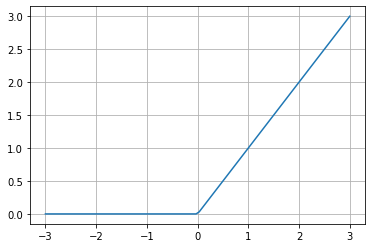

In [ ]:
plt.plot(x.numpy(), y.numpy())
plt.grid()
plt.show()

Now question is **How much better does our model do with this simple adjustment?**

In [ ]:
class MyNeuralNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
        self.R = nn.ReLU()   ## This is the only difference 
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

Train model (lets write a function to do this, since we'll be doing it a lot)

In [ ]:
def train_model(x,y,f, n_epochs=50):
    opt = SGD(f.parameters(), lr=0.001) #Optimizer 
    L = nn.MSELoss()                    # Loss function 

    # Train model
    losses = []
    for _ in range(n_epochs):
        opt.zero_grad() # flush previous epoch's gradient
        loss_value = L(f(x), y) #compute loss
        loss_value.backward() # compute gradient
        opt.step() # Perform iteration using gradient above
        losses.append(loss_value.item())
    return f, losses

In [ ]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f2 = MyNeuralNet2()

# Train model
f2, losses2 = train_model(x,y,f2, n_epochs=5000)

In [ ]:
y

tensor([1., 5., 2., 5.])

In [ ]:
f(x)

tensor([3.5283, 2.9805, 0.9094, 4.5583], grad_fn=<SqueezeBackward0>)

Slightly better. But the real advantage of this slight non-linearity is that we can make our matrices much larger. **Lets make our matrices size $80 \times 2 $ and  $1 \times 80 $**. This **only** works because of our non-linearity function $R(x)$:


 * Without $R(X)$ , we would just have $A_2A_1 = B$ and so $f(x)=Bx$ where $B$ is still a $1\times 2$ matrix even though $A_2$ and $A_1$ are larger matrices. The non-linearlity function $R(x)$  , to some extent , makes all $240$ parameters more independent from each other .

 $$\text{Old Model :} f(x) = A_2R(A_1x) \, , A_2 \, is \, 1\times 8 \, and \, A_1 \, is \, 8 \times 2 \\ \text{New Model:} f_3(x) = A_2R(A_1x)\, , A_2 \, is \, 1\times 80 \, and \, A_1 \, is \, 80 \times 2$$ 

In [ ]:
class MyNeuralNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80, bias=False)
        self.Matrix2 = nn.Linear(80,1, bias=False)
        self.R = nn.ReLU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

Train model:

In [ ]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f3 = MyNeuralNet3()

# Train model
f3, losses3 = train_model(x,y,f3, n_epochs=5000)

In [ ]:
y

tensor([1., 5., 2., 5.])

In [ ]:
f3(x)

tensor([1.8996, 3.7738, 1.9274, 5.1135], grad_fn=<SqueezeBackward0>)

Closer, but still not exact. We can make our model better by introducing other parameters:
$$f(x) =A_2R(A_1x+b_1)+b_2$$
where $b_1$ and $b_2$ are vectors added to each of the linear transformations.

 $$\text{Old Model :} f_3(x) = A_2R(A_1x)\, , A_2 \, is \, 1\times 80 \, and \, A_1 \, is \, 80 \times 2 \\ \text{New Model:} f_4(x) =A_2R(A_1x+b_1)+b_2\, , A_2 \, is \, 1\times 80 \, and \, A_1 \, is \, 80 \times 2$$ 

In [ ]:
class MyNeuralNet4(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80)
        self.Matrix2 = nn.Linear(80,1)
        self.R = nn.ReLU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

In [ ]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f4 = MyNeuralNet4()

# Train model
f4, losses4 = train_model(x,y,f4, n_epochs=5000)

In [ ]:
y

tensor([1., 5., 2., 5.])

In [ ]:
f4(x)

tensor([1.5699, 4.2764, 2.0183, 5.0369], grad_fn=<SqueezeBackward0>)

Better, but its still not getting us that close to $y$, however. What if we add another matrix in the middle?
 $$\text{Old Model :} f_4(x) =A_2R(A_1x+b_1)+b_2\, , A_2 \, is \, 1\times 80 \, and \, A_1 \, is \, 80 \times 2\\ \text{New Model:} f_5 (x) =  A_3R(A_2(A_1X+b_1)+b_2)+b_3 \, , A_3 \, is \, 1\times 80 \, and \, A_2 = 80 \times 80 \, and \, A_1 \, is \, 80 \times 2$$ 

In [ ]:
class MyNeuralNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80)
        self.Matrix2 = nn.Linear(80,80)
        self.Matrix3 = nn.Linear(80,1)
        self.R = nn.ReLU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f5 = MyNeuralNet5()

# Train model
f5, losses5 = train_model(x,y,f5, n_epochs=5000)

In [ ]:
y

tensor([1., 5., 2., 5.])

In [ ]:
f5(x)

tensor([1.0003, 4.9997, 2.0000, 5.0001], grad_fn=<SqueezeBackward0>)

Its predicting  almost exactly (albeit by overfitting, no doubt, but the message here is that the model has the potential to fit to these arbitrary data points, through a sequence of linear transofmrations followed by slightly non-linear )
$\require{color}$
# The "Sequential" Neural Network
A general "sequential" neural network can be expressed as
$$\colorbox{yellow}{$f(x) = \cal{K}_{i = 1}^nr_i(A_ix+b_i)$}$$

where  $\cal{K}_{i = 1}^nr_i(A_ix+b_i) = f_n \circ f_{n-1}... \circ f_1(x) $
  and the  are matrices and $A_i$ the $b_i$ are bias vectors. Typically the $R_i$ are the same for all the layers (typically ReLU) **except** for the last layer, where $R_i$ is just is just the identity function

  * **Note**: In clever architectures, like convolutional neural networks, the 's become sparse matrices (most of there parameters are fixed to equal zero).